In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.base import TransformerMixin
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer 
import matplotlib.pylab as plt
import matplotlib.patches as patches
from sklearn.metrics import roc_curve,auc
from numpy import interp

__Decision Tree: with imputation__

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df = pd.read_csv('bank-data/bank-additional-full.csv')
print(df.shape)
print(df.columns)
print((df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] == 'unknown').sum())

df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']].replace('unknown', np.NaN)
print(df.isnull().sum())

In [ ]:
bank_object_data = df.select_dtypes(include="object")
print(bank_object_data.info())

bank_non_object_data = df.select_dtypes(exclude="object")
print(bank_non_object_data.info())

values = bank_non_object_data.values
#imputer = Imputer()
transformed_values = imputer.fit_transform(values)
# count the number of NaN values in each column
print(np.isnan(transformed_values).sum())
print(np.isnan(bank_non_object_data.values).sum())

In [ ]:

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


bank_object_data = DataFrameImputer().fit_transform(bank_object_data)

In [ ]:
label = LabelEncoder()
bank_object_data = bank_object_data.apply(label.fit_transform)

print(bank_object_data.head())

bank_final = pd.concat([bank_object_data, bank_non_object_data], axis = 1)

print(bank_final.head())

__Decision Tree: with imputation; k fold and shuffle__

In [ ]:
X_train_res = bank_final.drop(['y'], axis = 1)
y_train_res = bank_final['y']

cv = KFold(n_splits=10, random_state=100, shuffle = True)
classifier = DecisionTreeClassifier(random_state=20)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 1
for train, test in cv.split(X_train_res, y_train_res):
    probas_ = classifier.fit(X_train_res.iloc[train], y_train_res.iloc[train]).predict_proba(X_train_res.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Decision Tree',fontsize=14)
plt.legend(loc="lower right", prop={'size': 10})
plt.show()

In [2]:
from joblib import dump
import os
import joblib

In [6]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



def DT(df):
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    df = pd.read_csv('bank-data/bank-additional-full.csv')

    df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']].replace('unknown', np.NaN)
    bank_object_data = df.select_dtypes(include="object")
    bank_non_object_data = df.select_dtypes(exclude="object")
    values = bank_non_object_data.values
    transformed_values = imputer.fit_transform(values)
    bank_object_data = DataFrameImputer().fit_transform(bank_object_data)
    label = LabelEncoder()
    bank_object_data = bank_object_data.apply(label.fit_transform)
    bank_final = pd.concat([bank_object_data, bank_non_object_data], axis = 1)

    X_train_res = bank_final.drop(['y'], axis = 1)
    y_train_res = bank_final['y']

    cv = KFold(n_splits=10, random_state=100, shuffle = True)
    classifier = DecisionTreeClassifier(random_state=20)
    
    cv_split_filenames = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    i = 1
    for train, test in cv.split(X_train_res, y_train_res):
        probas_ = classifier.fit(X_train_res.iloc[train], y_train_res.iloc[train]).predict_proba(X_train_res.iloc[test])
        
        cv_split_filenames = 'DT' + str(i)
        cv_split_filenames = os.path.abspath(cv_split_filenames)
        dump(probas_,cv_split_filenames)
        #cv_split_filenames.append(cv_split_filenames)
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of Decision Tree',fontsize=14)
    plt.legend(loc="lower right", prop={'size': 10})
    plt.show()


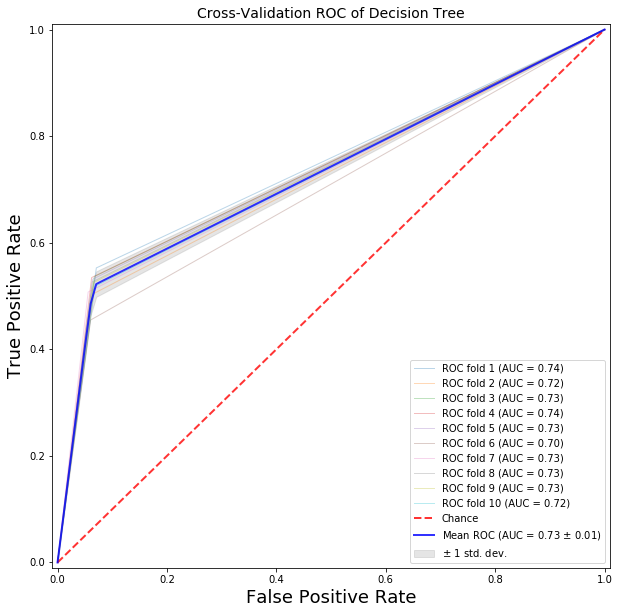

In [7]:
df = pd.read_csv('bank-data/bank-additional-full.csv')
DT(df)

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 1
for train, test in cv.split(X_train_res, y_train_res):
    probas_ = joblib.load('DT' + str(i),mmap_mode = 'c')
        
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of Decision Tree',fontsize=14)
plt.legend(loc="lower right", prop={'size': 10})
plt.show()
